# Find statistics based on a Whats' App discussion

This notebook will take as input a .csv of a Whats' App discussion and return some plots and statistics about the conversation. It may also generate a summary in PDF. 

The .csv has to be separated by ";" and have the following columns :
- UserName : The name of the sender of the message (str)
- MessageBody : The content of the message (str)
- Date2 : The date at which the message has been sent, datetime with the format YYYY-MM-DD
- Time : The hour at which the message has been sent, timedelta
- Date1 : Each first message of the day has the value of the date, other NaN, str, all can be NaN
- UserPhone : The phone number of the user, str, can be NaN
- MediaType : The type of media that has been sent with the message, str, can be NaN
- MediaLink : The link to this media, str, can be NaN
- QuotedMessage : The content of the quoted message (if any), str, can be NaN
- QuotedMessageDate : The date at which the quoted message has been sent, str, can be NaN
- QuotedMessageTime : The time at which the quoted message has been sent, str, can be NaN

The .csv can be created from the .txt that WhatsApp e-mails you when you export a conversation by using the other notebook "convert_txt_to_csv".

The current code has been developped as a hobby and thus is nor optimised nor completly clean, watch out before using it for a more important application. For a conversation of 718'899 messages and 4'618'207 words, the program takes (without PDF generation) 3m30s on my computer (Lenovo ThinkPad P50).

Other extensions of this notebook may be:
- Create an executable that allows non programmer to use the code 
- Develop an Android app that directly takes the message from whats app and generates the analysis
- Go further in the analysis, specially for the message content (TFID, sentiment analysis, ...)

Feel free to use my code for non-profit use. If you are gonna to earn money with it, please contact me at ivan.daniel.sievering@gmail.com. 

## 0. General settings

### 0.1 Parameters

In [1]:
# Wheere to find the conversation
FOLDER_NAME = "Example" # name of the folder
FILE_NAME = "data.csv" # name of the .csv

# Define the constants of the "discussion" definition
NB_MSG_TH = 2 # min nb of messages to be considered as a discussion
RESPONSE_TIME_TH = 120  # time btw two messages to be part of the same discussion (in minutes)

# Language to use for the stop words
language = "english"

# PDF generation
PDF = True # to create or not the PDF
PDF_NAME = FOLDER_NAME+ "/" + FOLDER_NAME + ".pdf" # path of the pdf if created

### 0.2 Libraries

In [2]:
import os
import pickle
import time

import numpy as np
import pandas as pd

import re
import collections

import matplotlib.pyplot as plt
import seaborn as sns

if PDF:
    import reportlab

# These libraries are called if the pickle with stop words of the language is not found :
# import nltk 
# import spacy.lang.fr 
# from stop_words import get_stop_words 
# import gensim 

## 0.3 Utilitary Functions

In [3]:
def get_stop_words(language="english"):
    """
    Aim: This function returns a list of stop words of the selected language
         It will first try to find the associated pickle, then try to load from internet and else return a void list
         Stop words are words that don't contain meaning
         
    Input:
        - language: the language of the stopwords
        
    Output:
        - stopwords: the list of stop words of the language
    """
    
    if language.lower() == "french":
        try:
            with open('stop_words_fusion_fr.pkl', 'rb') as f:
                return pickle.load(f)
        except:
            print("Pickle containing the french stopwords not found, trying to load one from Internet.")
    elif language.lower() == "english":
        try:
            with open('stop_words_fusion_en.pkl', 'rb') as f:
                return pickle.load(f)
        except:
            print("Pickle containing the english stopwords not found, trying to load one from Internet.")
            
    else:
        print("This language has no pickle associated to or the loading of the pickle failed."
              " Trying to download the words.")
        
        try:
            stop_words = []
            
            # nltk
            try:
                import nltk
                nltk.download('stopwords')
                stop_nltk = nltk.corpus.stopwords.words(language)
                stop_words = list(stop_words) + list(set(stop_nltk) - set(stop_words))
            except:
                print("Loading stop words from nltk failed for "+language)
                
            # stop_words
            try:
                from stop_words import get_stop_words
                stop_pip = get_stop_words(language)
                stop_words = list(stop_words) + list(set(stop_pip) - set(stop_words))
            except:
                print("Loading stop words from stop_words failed for "+language)
                
            # gensim
            try:
                import gensim
                stop_gensin = set(nltk.corpus.stopwords.words(language))
                stop_words = list(stop_words) + list(set(stop_gensin) - set(stop_words))
            except:
                print("Loading stop words from stop_words failed for "+language)
            
            return stop_words
        
        except:
            print("Loading of stop words in "+language+" failed. A void list will be used instead.")
            
            return []         

In [4]:
def plot_val_along_time(df, x_col, hue=None, plot_type="lineplot", y_col=None, title="Not set", 
                        x_label="Not set", y_label="Not set", savepath=None):
    """
    Aim: Plot the evolution of a column of the dataframe along time
         
    Input:
        - df: the dataframe that contains the data
        - x_col: the name of the column that will represent the x axis
        - hue: how to separate the data in various groups (None to do no separation)
        - plot_type: select if plot an histogram ("histplot") or a lineplot ("lineplot")
        - y_col: for lineplot, the column to use for the y axis
        - title: the title of the plot
        - x_label: the text on the x label
        - y_label: the text on the y label
        - savepath: name of the file to save it, None to not save it
        
    Output:
        - 
    """
    
    # Do not set the total transparent if there is no comparison
    alpha = 0.25
    if hue is None:
        alpha = 1
    
    # Define plot
    sns.set(font_scale=5)
    fig_dims = (80, 10)
    fig, ax = plt.subplots(figsize=fig_dims)
    
    # Draw data on it
    if plot_type == "histplot":
        sns.histplot(data=df, x=x_col, ax=ax, color="grey", alpha=alpha)
        if hue is not None:
            sns.histplot(data=df, x=x_col, hue=hue, ax=ax)
    elif plot_type == "lineplot":
        sns.lineplot(data=df, x=x_col, y=y_col, ax=ax, color="grey", alpha=alpha)
        if hue is not None:
            sns.lineplot(data=df, x=x_col, y=y_col, hue=hue, ax=ax)
    else:
        print("This type of plot is not implemented")
           
    # Show it
    ax.set(xlabel=x_label, ylabel=y_label)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.plot();
    if savepath is not None:
        plt.savefig(savepath, bbox_inches = 'tight')

In [5]:
def get_stats(current_df, column, measure_display="measure", index=False):
    """
    Aim: Show some statistics on a column of a dataframe
         
    Input:
        - df: the dataframe that contains the data
        - column: the name of the column that will be analysed
        - measure_display: name of what is being measured (only to display in the print)
        - index: true or false, to work with the index or the Date column to find most frequent cases
        
    Output:
        - the mean and the median of the value
    """
    
    column_of_interest = current_df[column]
    print("Mean "+measure_display+" "+str(column_of_interest.mean()))
    print("Median "+measure_display+" "+str(column_of_interest.median()))
    df_sorted = current_df.sort_values(by=column, ascending=False)
    print("\n5 most "+measure_display+" on:")
    for i in range(0,min(5,len(current_df)-1)):
        if index:
            print(str(df_sorted.index[i]) +": "+ str(df_sorted.iloc[i][column]))
        else:
            print(str(df_sorted.iloc[i]["Date"]) +": "+ str(df_sorted.iloc[i][column]))
            
    return column_of_interest.mean(), column_of_interest.median()

In [6]:
def get_stats_per_user(current_df, column, measure_display="measure", index=False):
    """
    Aim: Provide stats for each user by calling get_stats
         
    Input:
        - df: the dataframe that contains the data
        - column: the name of the column that will be analysed
        - measure_display: name of what is being measured (only to display in the print)
        - index: true or false, to work with the index or the Date column to find most frequent cases
        
    Output:
        - list of the users mean and median values
    """
    
    mean_l, median_l = [], []
    
    for user in users:
        print("Result for user: "+user)
        df_user = current_df[current_df["UserName"] == user]
        user_stat = get_stats(df_user, column, measure_display, index)
        mean_l.append(user_stat[0])
        median_l.append(user_stat[1])
        print("")
        
    return mean_l, median_l

## 1. Import  .csv to pd df

### 1.1 Load the df

In [7]:
df = pd.read_csv(os.path.join(FOLDER_NAME,FILE_NAME), sep=";",
                 dtype={'Date1':str,'MediaType':str,'MediaLink':str,
                        'QuotedMessage': str, 'QuotedMessageDate': str, 
                        'QuotedMessageTime': str, 'MessageBody':str})

### 1.2 Remove the useless data

In [8]:
df = df.drop(columns=["Date1","UserPhone","MediaType","MediaLink","QuotedMessage","QuotedMessageDate","QuotedMessageTime"])
try: # if from txt, this column has been added
    df = df.drop(columns=["Unnamed: 0"])
except: # Do nothing if the column does not exist
    assert True
df = df.rename(columns={"Date2":"Date"}) 

### 1.3 General information

In [9]:
# Find the list of people in the discussion
users = df["UserName"].unique()
print("Users are "+str(users))

Users are ['User1' 'User2']


In [10]:
# Data will be considered month-wise, add a column to fasten furhter operations 
# !! This operation is not optimised !!
df["Month"] = pd.to_datetime(df["Date"], format='%Y-%m-%d').apply(lambda x: x.strftime('%Y-%m'))

In [11]:
# Add a column with the full date  
# !? This operation may be done in an easier way ?!
# Get total number of seconds
tot_sec = abs((df["Time"]/np.timedelta64(1, 's')).astype(int))
# Find hour minute and seconds of the day as string with leading zeros
seconds =  (tot_sec%(60)).astype(int).astype(str).str.zfill(2)
minutes= ((tot_sec%3600)/(60)).astype(int).astype(str).str.zfill(2)
hours = (tot_sec/3600).astype(int).astype(str).str.zfill(2)
# Create the date as a datetime
df["FullDate"] = df["Date"]+" "+hours+":"+minutes+":"+seconds
df["FullDate"] = pd.to_datetime(df["FullDate"],format= '%Y-%m-%d %H:%M:%S')

### 1.4 Treat the content of the message

#### 1.4.1 Create column of cleaned phrases for phrase analysis

In [12]:
# Define what is an emoji to remove them, from https://stackoverflow.com/questions/53762880/how-to-convert-text-in-pandas-dataframe-delete-punctuation-split-text-into-one
emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)

# Create a new column with cleaner message information
df['MessagePhrase'] = (df['MessageBody'].str.lower() #lowercase
                            .str.replace(r'\\n',' ', regex=True) # convert new line to space
                            .str.replace(r'\n',' ', regex=True) # convert new line to space (other format)
                            .str.replace(emoji_pattern, '') #remove emojis
                            .str.strip() #rem trailing whitespaces
                            .astype(str) # convert all to string (including NaN)
                          )

In [13]:
# Count the number of phrases in each message
phrase_serie = df["MessagePhrase"].str[:-1] # remove last charach (may be a punctuation)
phrase_serie= phrase_serie.str.replace(r'(\w)\1{%d,}'%(2), r'\1') # remove repeated charachs 
                                  # may be ... -> . or ??? -> ? and thus count various time

# Count the apparition of each possible punctuation separator (+1, a message without puncutation has one sentence)
df["PhraseCount"] = phrase_serie.str.count('\\.')
df["PhraseCount"] += phrase_serie.str.count('\\?')
df["PhraseCount"] += phrase_serie.str.count('\\!')
df["PhraseCount"] += phrase_serie.str.count('\\\n')
df["PhraseCount"] = df["PhraseCount"] + 1

#### 1.4.2 Create column of cleaned phrases for word analysis

In [14]:
# Remove the punctuation and create the words column
df['MessageWord'] = df['MessagePhrase'].str.replace(r'[^\w\s]+', ' ')

In [15]:
# Count the number of words in each message
df["WordCount"] = df['MessageWord'].str.count(' ')
df["WordCount"] = df["WordCount"] + 1

#### 1.4.2 Create a column of cleaned words without stop words

In [16]:
# Load the stop words
stop_words = get_stop_words(language)
        
# Create a column without them (!! takes a some time proportional to the size of the discussion !!)
pattern = r'\b(?:{})\b'.format('|'.join(stop_words))
df["MessageWordWithoutStopWord"] = df['MessageWord'].str.replace(pattern, '')
df["MessageWordWithoutStopWord"] = df['MessageWordWithoutStopWord'].str.replace(r'\s+', ' ')

# Count the number of non stop words in each message
df["WordCountNonStop"] = df['MessageWordWithoutStopWord'].str.count(' ')
df["WordCountNonStop"] = df["WordCountNonStop"] + 1

### 1.5 Show the data that will be used

In [17]:
df.head()

,MessageBody,Date,UserName,Time,Month,FullDate,MessagePhrase,PhraseCount,MessageWord,WordCount,MessageWordWithoutStopWord,WordCountNonStop
0,Hi!,2017-05-29,User1,0 days 11:52:00,2017-05,2017-05-29 11:52:00,hi!,1,hi,2,hi,2
1,Hi!,2017-05-29,User2,0 days 11:54:00,2017-05,2017-05-29 11:54:00,hi!,1,hi,2,hi,2
2,How do you do ?,2017-05-29,User2,0 days 12:52:00,2017-05,2017-05-29 12:52:00,how do you do ?,1,how do you do,6,,2
3,I want to say something important about us...,2017-05-29,User2,0 days 12:54:00,2017-05,2017-05-29 12:54:00,i want to say something important about us...,3,i want to say something important about us,9,want important,4
4,Hmmm... What?,2017-05-29,User1,0 days 13:22:00,2017-05,2017-05-29 13:22:00,hmmm... what?,4,hmmm what,4,hmmm,2


In [18]:
df.tail()

,MessageBody,Date,UserName,Time,Month,FullDate,MessagePhrase,PhraseCount,MessageWord,WordCount,MessageWordWithoutStopWord,WordCountNonStop
9,"Ow, I thought that you were single",2017-05-30,User2,0 days 11:52:00,2017-05,2017-05-30 11:52:00,"ow, i thought that you were single",1,ow i thought that you were single,8,ow thought single,3
10,I am sad now,2017-05-30,User2,0 days 11:52:00,2017-05,2017-05-30 11:52:00,i am sad now,1,i am sad now,4,sad,3
11,"Don't worry, you will find your love at Puert...",2017-06-01,User1,0 days 11:52:00,2017-06,2017-06-01 11:52:00,"don't worry, you will find your love at puerto...",1,don t worry you will find your love at puerto...,12,worry find love puerto rico,6
12,I don't need to go there... I already found m...,2017-06-02,User2,0 days 11:53:00,2017-06,2017-06-02 11:53:00,i don't need to go there... i already found my...,7,i don t need to go there i already found my l...,17,need found love,5
13,"Nah, I am too ugly for that. .",2017-06-02,User1,0 days 11:55:00,2017-06,2017-06-02 11:55:00,"nah, i am too ugly for that. .",2,nah i am too ugly for that,11,nah ugly,3


## 2. Prepare specific df

### 2.1 Response Time between messages

Look at how many time elapses between various messages

#### 2.1.1 All response 

The response time considers the last message, independtly of the user, this may be enhanced

In [19]:
# Copy for safety
df_response_time = df.copy()

# Compute distance in time btw two msgs
df_response_time["ResponseTime"] = (df_response_time["FullDate"] - df_response_time["FullDate"].shift(1))

# Remove first row which is a NaT (not a time) because comparing to nothing 
df_response_time = df_response_time[1:]

# Convert to minute
df_response_time["ResponseTime"] = abs(df_response_time["ResponseTime"].dt.total_seconds()/60)

#### 2.1.2 Response to other user

The response time considers the last message send by the other user. It is a bit biased because the other person may have send a new message in between.

In [20]:
# Copy for safety
df_response_time_users = df.copy()

# Remove messages that follow the same user message
mask_same_user_msg = df_response_time_users["UserName"] != df_response_time_users["UserName"].shift(1)
df_response_time_users = df_response_time_users[mask_same_user_msg]

# Compute distance
df_response_time_users["ResponseTime"] = df_response_time_users["FullDate"] - df_response_time_users["FullDate"].shift(1)

# Remove first row which is a NaT (not a time) because comparing to nothing 
df_response_time_users = df_response_time_users[1:]

# Convert to minute
df_response_time_users["ResponseTime"] = abs(df_response_time_users["ResponseTime"].dt.total_seconds()/60)

### 2.2. Find the discussions in the dataset

A group of messages are considered as a discussion if at least two users are involved, at least NB_MSG_TH are exchanged and the distance between each message is maximum RESPONSE_TIME_TH.

In [21]:
# For this operation, we need the distance between all the message
df_discussion = df_response_time.copy()

In [22]:
# A discussion starts always with a messages that lasted more than RESPONSE_TIME_TH
df_discussion_start = df_discussion[df_discussion["ResponseTime"]>RESPONSE_TIME_TH]

# Add a column for each message that defines to which discussion it belogns
df_discussion["discussion_id"] = np.nan

# Add to the starting discussion messages their discussion id
df_discussion.loc[df_discussion_start.index, "discussion_id"] = df_discussion_start.index.values

# Assing the discusion id to the start discussion messages
df_discussion["discussion_id"] = df_discussion["discussion_id"].ffill()

# Look at the number of messages in each discussion
df_discussion_cnt = df_discussion.groupby(by="discussion_id").count()

# Keep only the ones with enough messages
df_discussion_cnt = df_discussion_cnt[df_discussion_cnt["UserName"] > NB_MSG_TH]
df_discussion = df_discussion[df_discussion['discussion_id'].isin(df_discussion_cnt.index)]

# Check that the conversation have at least two users
df_discussion_both = df_discussion.groupby(by="discussion_id").agg({"UserName": "nunique"})
df_discussion_both = df_discussion_both[df_discussion_both["UserName"]>1]
df_discussion = df_discussion[df_discussion['discussion_id'].isin(df_discussion_both.index)]

In [23]:
# Show some example
if len(df_discussion) == 0:
    print("No discussion found with these parameters, try with others.\nNo plot stats related to discussion will be given.")

### 2.3 Create word dataframe

#### 2.3.1 Counter of words

In [24]:
# Global (words are separated by " " in our MessageWord column)
all_words_count = collections.Counter("".join(df["MessageWord"]).split())

# For each user
all_words_count_per_user_l = []
for user in users:
    reduced_df = df[df["UserName"]==user]
    all_words_count_per_user_l.append(collections.Counter("".join(reduced_df["MessageWord"]).split()))

#### 2.3.2 Counter of words without stop words

In [25]:
# Global
# create list
word_list_without_stopword = "".join(df["MessageWordWithoutStopWord"]).split()
# only keep the words of at least 2 letters 
# !! Not optimsied due to the use of lamda !!
word_list_without_stopword = list(filter(lambda i: len(i) > 1, word_list_without_stopword))
# count the words
all_words_count_no_stopword = collections.Counter(word_list_without_stopword)

# For each user
all_words_no_stop_count_per_user_l = []
for user in users:
    reduced_df = df[df["UserName"]==user]
    word_list_without_stopword_user = "".join(reduced_df["MessageWordWithoutStopWord"]).split()
    word_list_without_stopword_user = list(filter(lambda i: len(i) > 1, word_list_without_stopword_user))
    all_words_no_stop_count_per_user_l.append(collections.Counter(word_list_without_stopword_user))

#### 2.3.3 Counter of phrases

In [26]:
# Global
# Get the list of phrases (explode with the different separators)
phrase_list = df["MessagePhrase"].str.split("?").explode()
phrase_list = phrase_list.str.split("!").explode()
phrase_list = phrase_list.str.split(".").explode()
phrase_list = phrase_list.str.split(",").explode()
phrase_list = phrase_list.str.split("\n").explode()

# Convert it to pandas to work with them in an easier way
phrase_df = pd.DataFrame(phrase_list)
phrase_df["MessageBodyPhrase"] = phrase_df["MessagePhrase"].str.lstrip()

# Create a counter column
phrase_df["Count"] = 1

# Group them to count them and order them by frequency
most_freq_phrase_df = phrase_df.groupby(by="MessagePhrase").sum().sort_values(by="Count",ascending=False)

# Only keep the ones with at least 3 words
most_freq_phrase_df["WordCount"] =  most_freq_phrase_df.index.str.count(' ') 
most_freq_phrase_df["WordCount"] = most_freq_phrase_df["WordCount"] + 1
most_freq_phrase_df = most_freq_phrase_df[most_freq_phrase_df["WordCount"] >= 3]

# Per user
all_phrase_count_per_user_l = []
for user in users:
    df_reduced = df[df["UserName"] == user]
    
    phrase_list_user = df_reduced["MessagePhrase"].str.split("?").explode()
    phrase_list_user = phrase_list_user.str.split("!").explode()
    phrase_list_user = phrase_list_user.str.split(".").explode()
    phrase_list_user = phrase_list_user.str.split(",").explode()
    phrase_list_user = phrase_list_user.str.split("\n").explode()

    phrase_df_user = pd.DataFrame(phrase_list_user)
    phrase_df_user["MessageBodyPhrase"] = phrase_df_user["MessagePhrase"].str.lstrip()

    phrase_df_user["Count"] = 1
    most_freq_phrase_df_user = phrase_df_user.groupby(by="MessagePhrase").sum().sort_values(by="Count",ascending=False)

    most_freq_phrase_df_user["WordCount"] =  most_freq_phrase_df_user.index.str.count(' ') 
    most_freq_phrase_df_user["WordCount"] = most_freq_phrase_df_user["WordCount"] + 1
    most_freq_phrase_df_user = most_freq_phrase_df_user[most_freq_phrase_df_user["WordCount"] >= 3]
    all_phrase_count_per_user_l.append(most_freq_phrase_df_user)

## 3. Results

### 3.1 Number of messages

Stats regarding the number of messages sent

In [27]:
total_nb_msg = len(df)
print("Total number of messages "+str(total_nb_msg))

Total number of messages 14


In [28]:
# Regroup messages per day
msg_count_per_day = pd.DataFrame(df.groupby(["Date","UserName"]).agg({"Time": "count"}))
msg_count_per_day = msg_count_per_day.rename(columns={"Time":"NbMessages"})
msg_count_per_day = msg_count_per_day.reset_index(level=1)

# Show stats
msg_count_stats = get_stats(msg_count_per_day.groupby("Date").sum(), "NbMessages", 
                            measure_display="number of messages per day", index=True)
print("")
msg_count_stats_per_user = get_stats_per_user(msg_count_per_day, "NbMessages", 
                                              measure_display="number of messages per day", index=True)

Mean number of messages per day 3.5
Median number of messages per day 3.5

5 most number of messages per day on:
2017-05-29: 6
2017-05-30: 5
2017-06-02: 2

Result for user: User1
Mean number of messages per day 1.5
Median number of messages per day 1.5

5 most number of messages per day on:
2017-05-29: 2
2017-05-30: 2
2017-06-01: 1

Result for user: User2
Mean number of messages per day 2.6666666666666665
Median number of messages per day 3.0

5 most number of messages per day on:
2017-05-29: 4
2017-05-30: 3



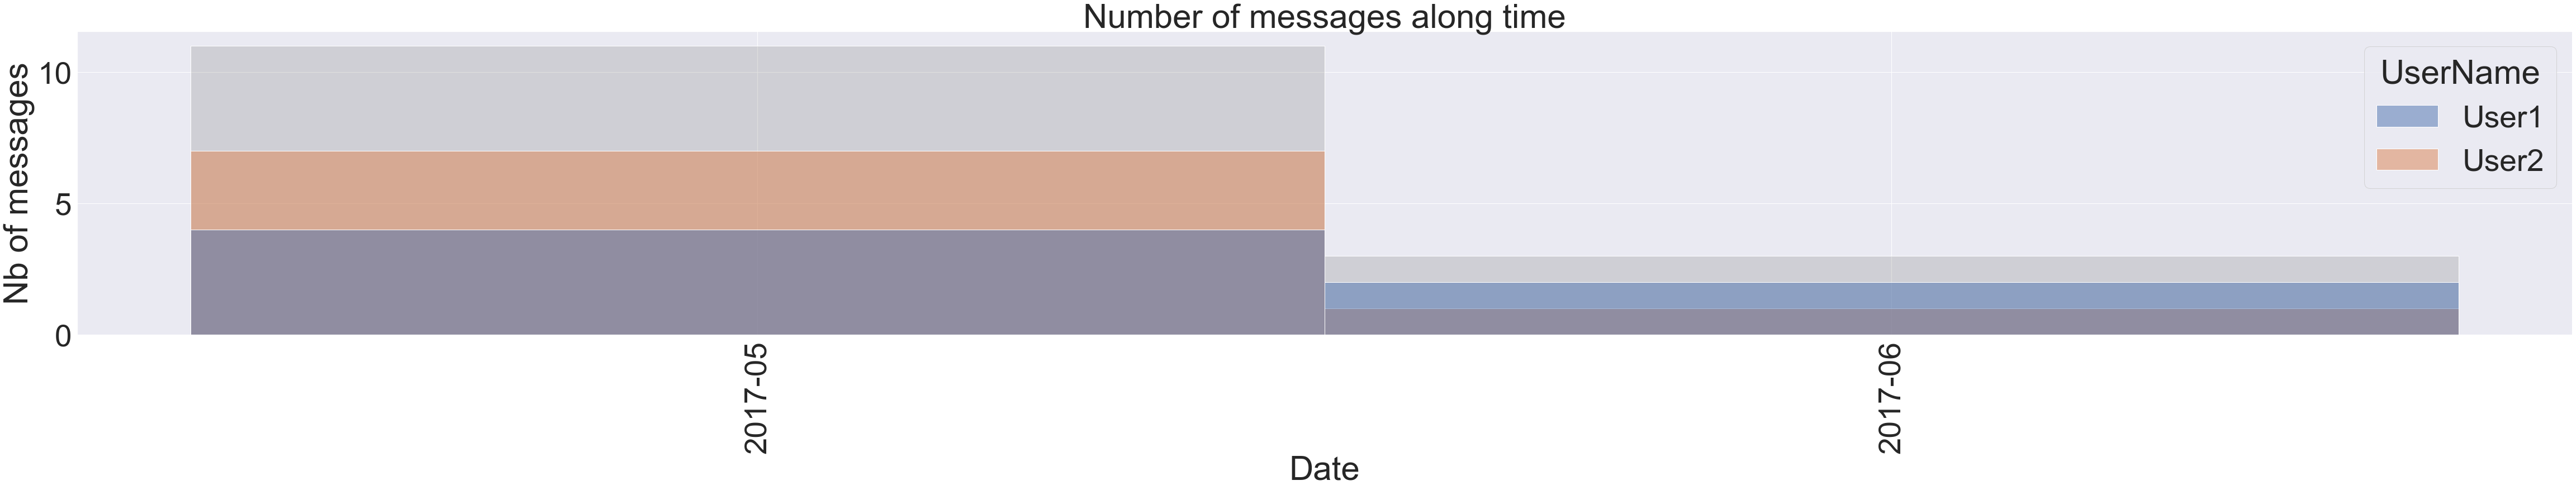

In [29]:
plot_val_along_time(df, x_col="Month", hue="UserName", plot_type="histplot", 
                    title="Number of messages along time", x_label="Date", y_label="Nb of messages", 
                    savepath=os.path.join(FOLDER_NAME,"nb_msg_time.png"))

### 3.2 Response Time Between users

Time to respond to last message of the OTHER user.

In [30]:
response_time_stats = get_stats(df_response_time_users, "ResponseTime", 
                                "delay between messages (m)", index=False)

Mean delay between messages (m) 720.375
Median delay between messages (m) 135.0

5 most delay between messages (m) on:
2017-06-01: 2880.0
2017-06-02: 1441.0
2017-05-30: 1080.0000000000002
2017-05-29: 150.0
2017-05-30: 120.0


In [31]:
response_time_stats_per_user = get_stats_per_user(df_response_time_users, "ResponseTime", 
                                                  "delay between messages (m)", index = False)

Result for user: User1
Mean delay between messages (m) 1012.5
Median delay between messages (m) 584.0000000000001

5 most delay between messages (m) on:
2017-06-01: 2880.0
2017-05-30: 1080.0000000000002
2017-05-29: 88.0

Result for user: User2
Mean delay between messages (m) 428.25
Median delay between messages (m) 135.0

5 most delay between messages (m) on:
2017-06-02: 1441.0
2017-05-29: 150.0
2017-05-30: 120.0



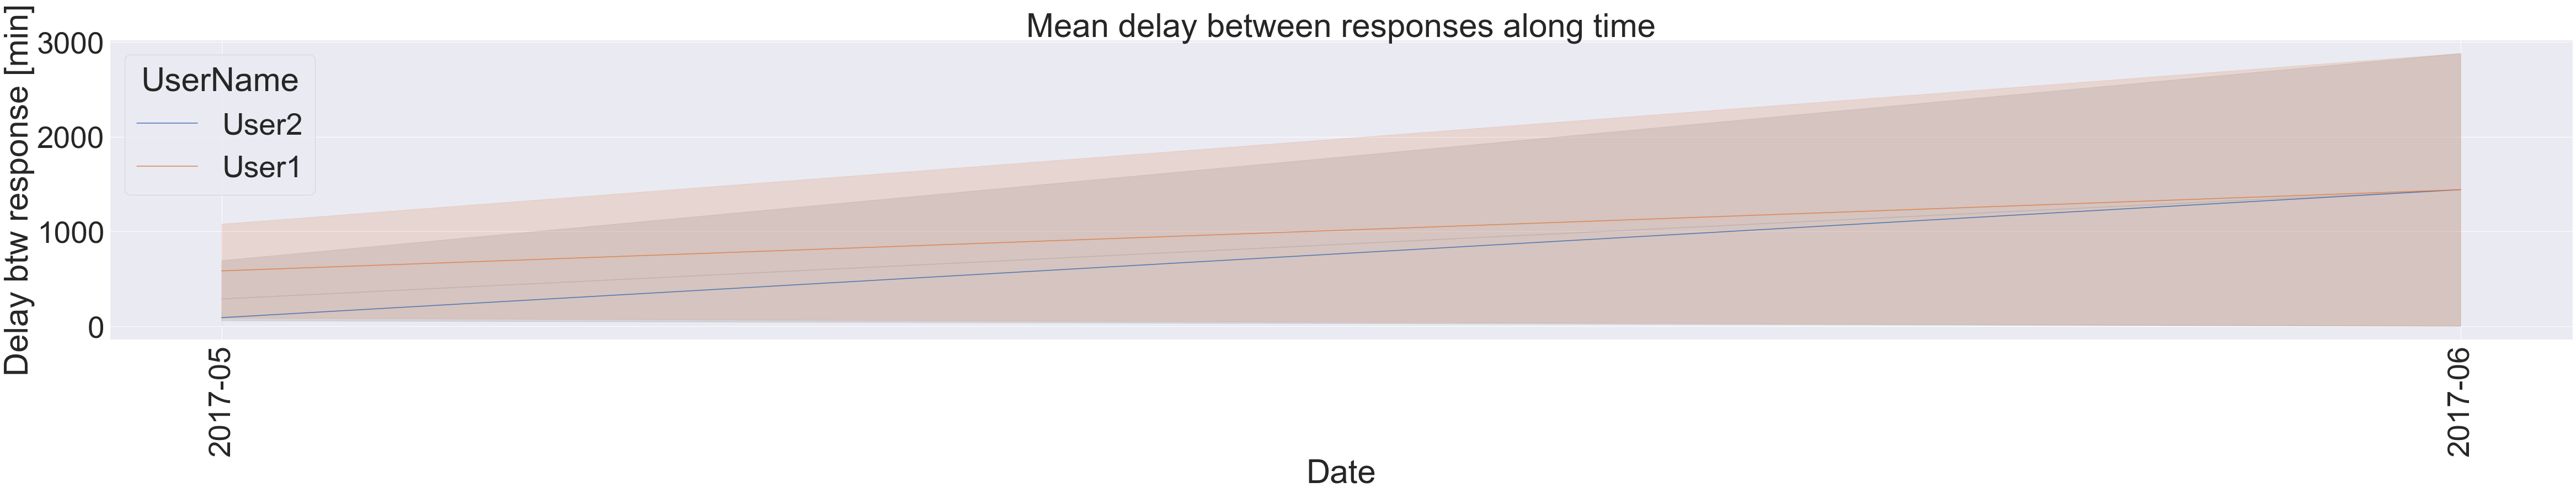

In [32]:
plot_val_along_time(df_response_time_users, x_col="Month", y_col="ResponseTime", hue="UserName", plot_type="lineplot", 
                    title="Mean delay between responses along time", x_label="Date", y_label="Delay btw response [min]", 
                    savepath=os.path.join(FOLDER_NAME,"delay_time.png"))

### 3.3 Discussions

A group of messages are considered as a discussion if at least two users are involved, at least NB_MSG_TH are exchanged and the distance between each message is maximum RESPONSE_TIME_TH.

#### 3.3.1 Nb of discussions per month

In [33]:
nb_discussion = df_discussion["discussion_id"].nunique()
print("Total of {} discussions".format(nb_discussion))

Total of 1 discussions


In [34]:
if len(df_discussion) > 0:
    # Group per month
    df_discussion_per_month = df_discussion.groupby("Month").agg({"discussion_id": "nunique"})
    # Get stats
    nb_disc_stats = get_stats(df_discussion_per_month, "discussion_id", measure_display="discussions", index=True)
else:
    print("Not enough data to make stats on discussion.")

Mean discussions 1.0
Median discussions 1.0

5 most discussions on:


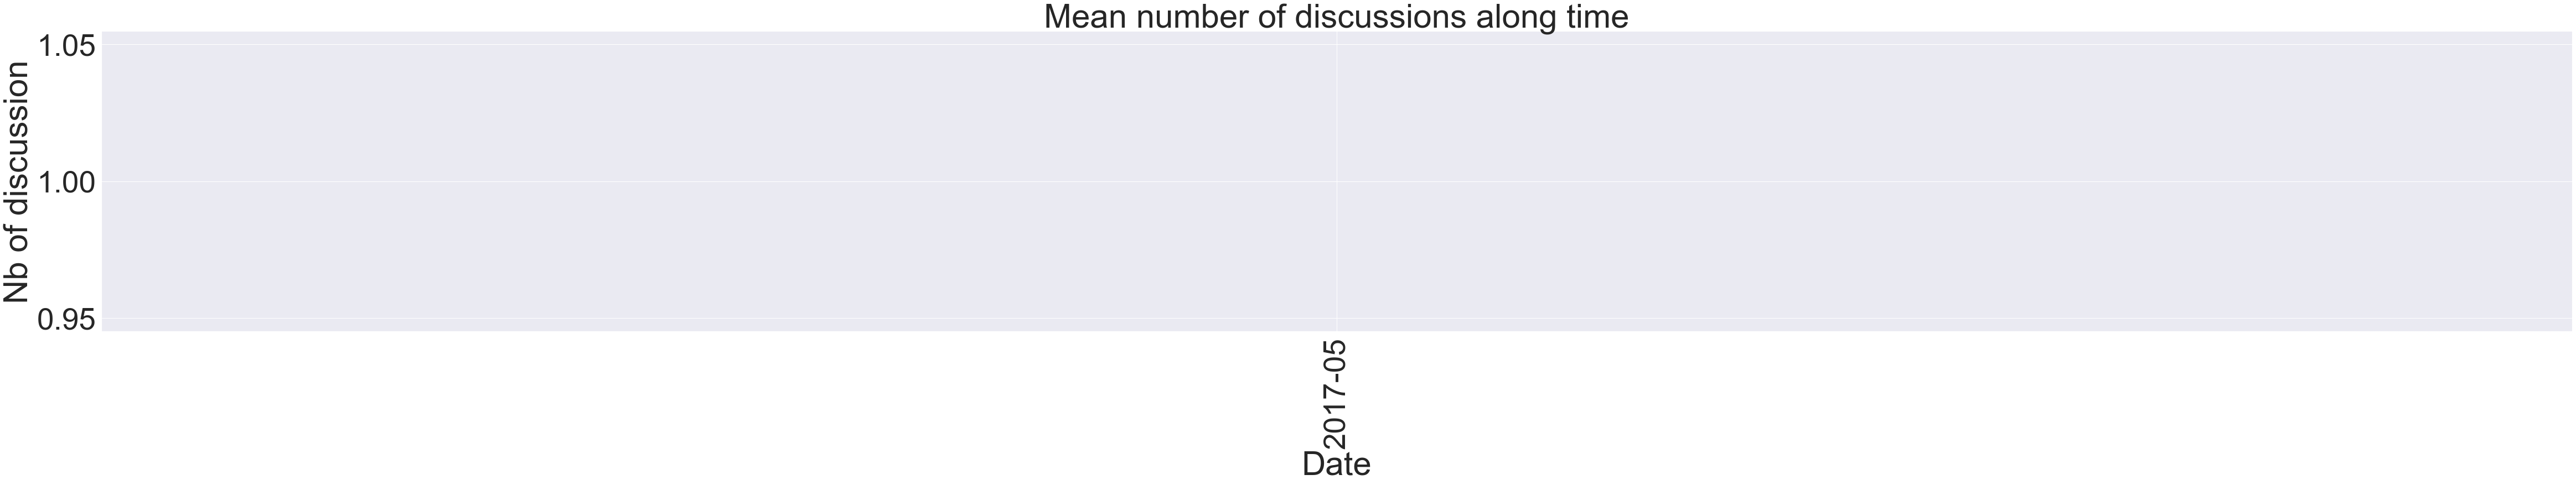

In [35]:
if len(df_discussion) > 0:
    plot_val_along_time(df_discussion_per_month, x_col="Month", hue=None, plot_type="lineplot", y_col="discussion_id",
                        title="Mean number of discussions along time", x_label="Date", y_label="Nb of discussion", 
                        savepath=os.path.join(FOLDER_NAME,"nb_disc_time.png"))
else:
    print("Not enough data to make stats on discussion.")

#### 3.3.2 Percentage of messages in discussion

In [36]:
# Get the number of message in discussion each month
df_msg_in_discussion_per_month = df_discussion.groupby("Month").agg({"discussion_id": "count"})

# Get the total number of message each month
tot_nb_messages_per_month = df.groupby(by="Month").count()["Time"]

# Create percentage of message in discussion array (need to have same format)
perc_msg_discussion_per_month = tot_nb_messages_per_month.copy()
perc_msg_discussion_per_month.values[:] = 0

# Fill it and divide by total number
perc_msg_discussion_per_month[df_msg_in_discussion_per_month.index] = df_msg_in_discussion_per_month["discussion_id"]
perc_msg_discussion_per_month = pd.DataFrame(perc_msg_discussion_per_month/tot_nb_messages_per_month)
perc_msg_discussion_per_month = perc_msg_discussion_per_month.rename(columns={"Time":"Percentage"})

In [37]:
if len(df_discussion) > 0:
    perc_disc_stats = get_stats(perc_msg_discussion_per_month, "Percentage", 
                                measure_display="percentage of messages in discussion", index=True)
else:
    print("Not enough data to make stats on discussion.")

Mean percentage of messages in discussion 0.22727272727272727
Median percentage of messages in discussion 0.22727272727272727

5 most percentage of messages in discussion on:
2017-05: 0.45454545454545453


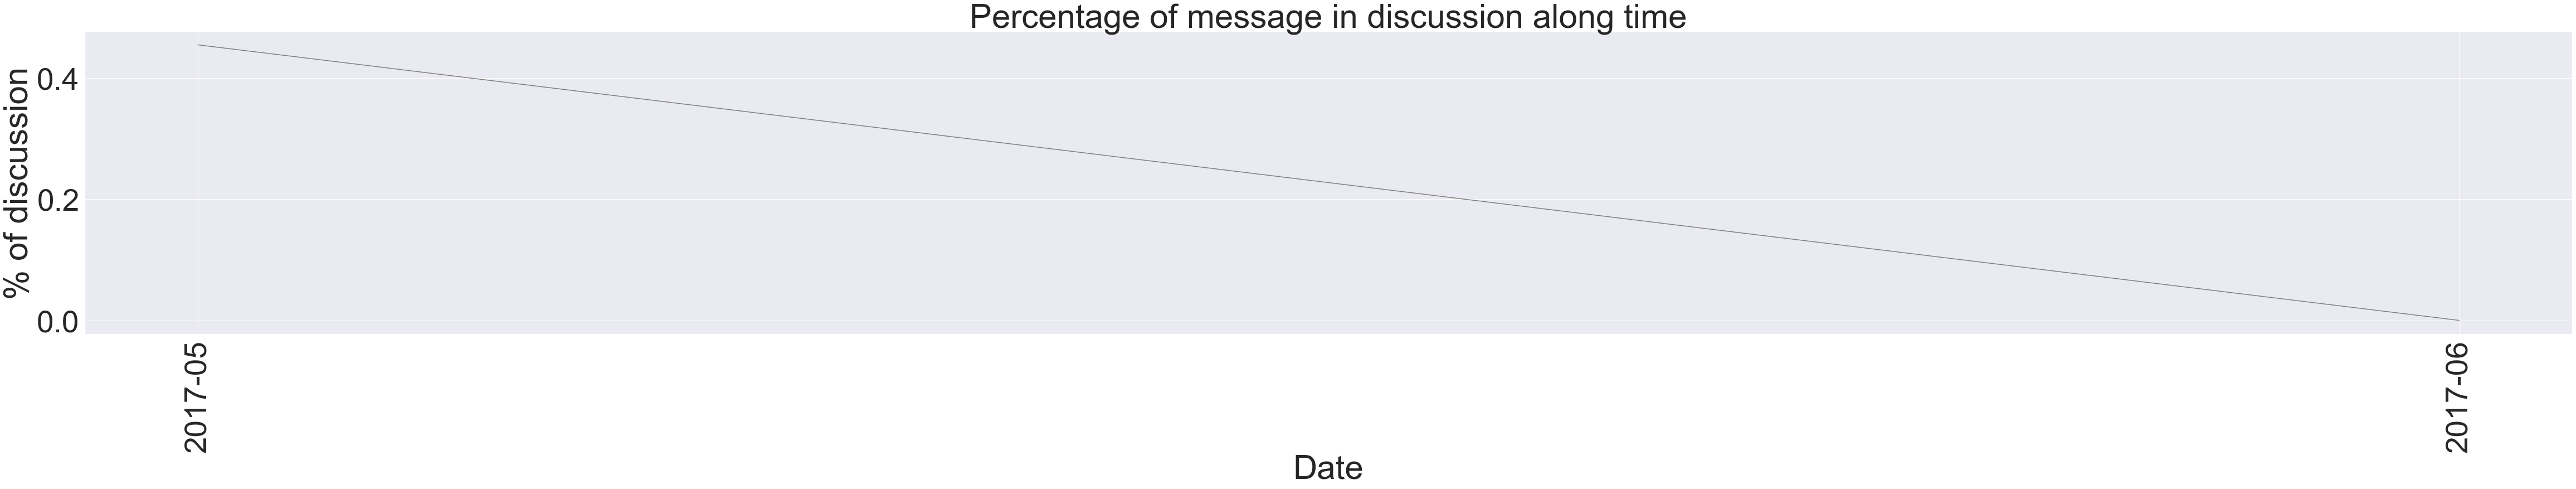

In [38]:
if len(df_discussion) > 0:
    plot_val_along_time(perc_msg_discussion_per_month, x_col="Month", hue=None, plot_type="lineplot", y_col="Percentage",
                        title="Percentage of message in discussion along time", x_label="Date", y_label="% of discussion", 
                        savepath=os.path.join(FOLDER_NAME,"perc_disc_time.png"))
else:
    print("Not enough data to make stats on discussion.")

#### 3.3.3 Time spent in discussion

In [39]:
# Find last and first message of each discussion
df_last_msg = df_discussion.groupby(by="discussion_id").agg({"FullDate": "max"})
df_first_msg = df_discussion.groupby(by="discussion_id").agg({"FullDate": "min"})

# Compute the duration in hours
df_discussion_duration = (df_last_msg["FullDate"]-df_first_msg["FullDate"])
df_discussion_duration = df_discussion_duration.dt.total_seconds()/(60*60)

# Find the month in which the discussion happened 
df_discussion_date = df_discussion.groupby(by="discussion_id").agg(pd.Series.mode)["Month"]

# Create the dataframe of duration from the series above
df_discussion_duration_tot = pd.DataFrame(df_discussion_duration).rename(columns={"FullDate":"duration"})
df_discussion_duration_tot["Month"] = df_discussion_date

# Regroup per month
df_discussion_duration_tot_per_month = df_discussion_duration_tot.groupby(by="Month").sum()

In [40]:
if len(df_discussion) > 0:
    # Compute the time spent in discussion
    df_discussion_duration_tot_tmp = df_discussion_duration_tot.copy()
    df_discussion_duration_tot_tmp["Month"] = df_discussion_duration_tot_tmp["duration"].astype(float)
    df_discussion_duration_tot_per_month_tmp = df_discussion_duration_tot_tmp.groupby(by="Month").sum()
    tot_time_spent_disc_h = df_discussion_duration_tot_per_month_tmp["duration"].sum()
    print("Total time spent in discussion [h] "+str(tot_time_spent_disc_h))
    print("Total time spent in discussion [d] "+str(tot_time_spent_disc_h/24))
else:
    print("Not enough data to make stats on discussion.")

Total time spent in discussion [h] 3.0
Total time spent in discussion [d] 0.125


In [41]:
if len(df_discussion) > 0:
    time_disc_stats = get_stats(df_discussion_duration_tot_per_month_tmp, "duration", 
                                measure_display="duration of discussion [h]", index=True)
else:
    print("Not enough data to make stats on discussion.")

Mean duration of discussion [h] 3.0
Median duration of discussion [h] 3.0

5 most duration of discussion [h] on:


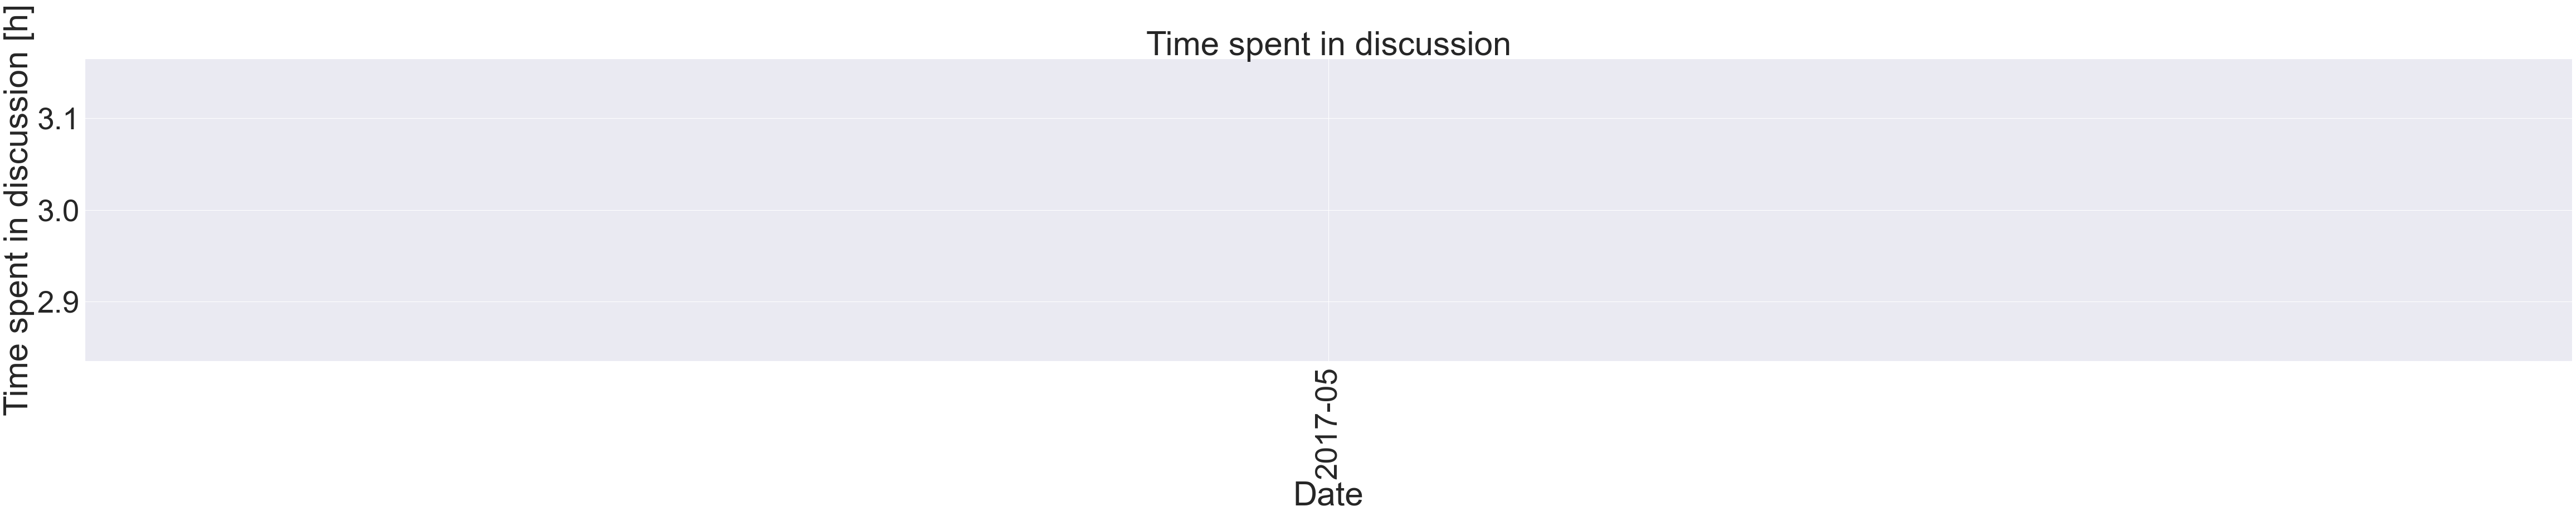

In [42]:
if len(df_discussion) > 0:
    plot_val_along_time(df_discussion_duration_tot_per_month, x_col="Month", hue=None, plot_type="lineplot", y_col="duration",
                        title="Time spent in discussion", x_label="Date", y_label="Time spent in discussion [h]", 
                        savepath=os.path.join(FOLDER_NAME,"time_disc_time.png"))
else:
    print("Not enough data to make stats on discussion.")

## 3.4 Message content analysis

### 3.4.1 Restrain the df

In [43]:
# Remove message that are void (mainly because smiley were removed)
df_message_content = df.copy()
df_message_content = df_message_content[df_message_content["MessagePhrase"]!=""]
df_message_content = df_message_content[df_message_content["MessagePhrase"]!=" "]

### 3.4.2 Work with words

If your conversation is short, some words may appear as most frequent but just appear one time.

In [44]:
# Group per day
word_count_per_day = pd.DataFrame(df_message_content.groupby(["Date","UserName"]).agg({"WordCount": "sum"}))
word_count_per_day = word_count_per_day.rename(columns={"WordCount":"NbWords"})
word_count_per_day = word_count_per_day.reset_index(level=1)

# Compute total
tot_nb_words = word_count_per_day["NbWords"].sum()
print("Total numbre of words: "+str(tot_nb_words)+"\n")

# Get precise stats
words_stats = get_stats(word_count_per_day.groupby("Date").sum(), "NbWords", 
                        measure_display="number of words per day", index=True)
print("")
words_stats_per_user = get_stats_per_user(word_count_per_day, "NbWords", 
                                          measure_display="number of words per day", index=True)

Total numbre of words: 93

Mean number of words per day 23.25
Median number of words per day 26.0

5 most number of words per day on:
2017-05-29: 29
2017-06-02: 28
2017-05-30: 24

Result for user: User1
Mean number of words per day 9.75
Median number of words per day 10.5

5 most number of words per day on:
2017-06-01: 12
2017-06-02: 11
2017-05-30: 10

Result for user: User2
Mean number of words per day 18.0
Median number of words per day 17.0

5 most number of words per day on:
2017-05-29: 23
2017-06-02: 17



In [45]:
# Explode the df for each word (have one row per word --> easier to do the histogram)
words_per_month = df_message_content.copy()
words_per_month["MessageWord"] = words_per_month["MessageWord"].str.split(" ")
words_per_month = words_per_month.explode("MessageWord")

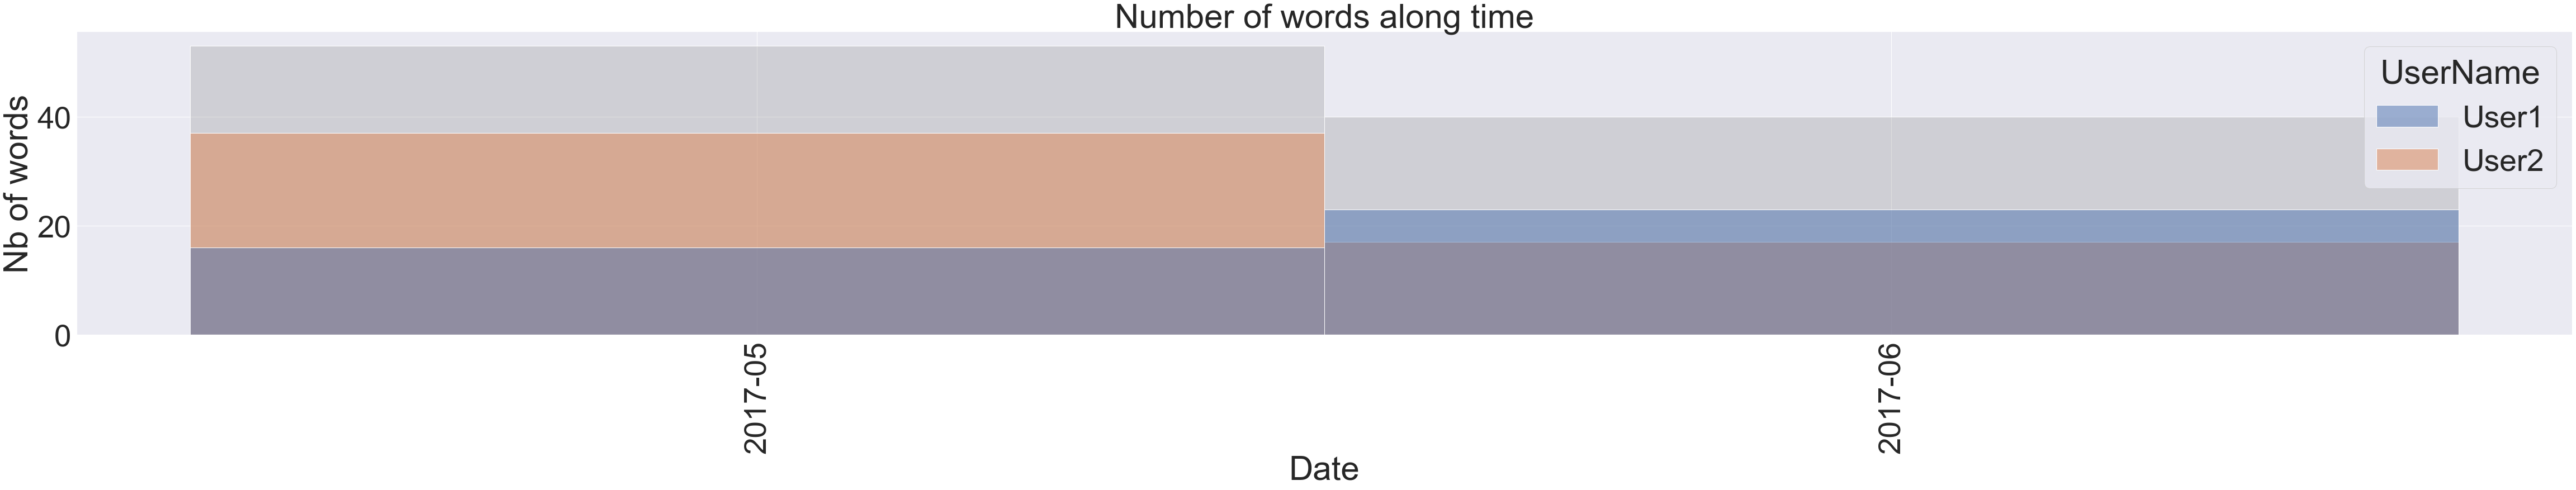

In [46]:
plot_val_along_time(words_per_month, x_col="Month", hue="UserName", plot_type="histplot",
                    title="Number of words along time", x_label="Date", y_label="Nb of words", 
                    savepath=os.path.join(FOLDER_NAME,"words_time.png"))

In [47]:
print("The 50 most used words")
most_common_words = all_words_count.most_common(50)
print(most_common_words)

The 50 most used words
[('i', 7), ('you', 4), ('that', 3), ('love', 3), ('hi', 2), ('do', 2), ('to', 2), ('my', 2), ('am', 2), ('t', 2), ('how', 1), ('want', 1), ('say', 1), ('something', 1), ('important', 1), ('about', 1), ('us', 1), ('hmmm', 1), ('what', 1), ('think', 1), ('youpls', 1), ('answersorry', 1), ('was', 1), ('with', 1), ('boyfriendbut', 1), ('are', 1), ('cuteow', 1), ('thought', 1), ('were', 1), ('singlei', 1), ('sad', 1), ('nowdon', 1), ('worry', 1), ('will', 1), ('find', 1), ('your', 1), ('at', 1), ('puerto', 1), ('ricoi', 1), ('don', 1), ('need', 1), ('go', 1), ('there', 1), ('already', 1), ('found', 1), ('it', 1), ('is', 1), ('younah', 1), ('too', 1), ('ugly', 1)]


In [48]:
for i, user in enumerate(users):
    print("The 20 most used words for user {}".format(user))
    print(all_words_count_per_user_l[i].most_common(20))
    print("\n")

The 20 most used words for user User1
[('i', 2), ('you', 2), ('hi', 1), ('hmmm', 1), ('what', 1), ('sorry', 1), ('was', 1), ('with', 1), ('my', 1), ('boyfriendbut', 1), ('are', 1), ('cutedon', 1), ('t', 1), ('worry', 1), ('will', 1), ('find', 1), ('your', 1), ('love', 1), ('at', 1), ('puerto', 1)]


The 20 most used words for user User2
[('i', 5), ('you', 3), ('do', 2), ('to', 2), ('that', 2), ('love', 2), ('hi', 1), ('how', 1), ('want', 1), ('say', 1), ('something', 1), ('important', 1), ('about', 1), ('us', 1), ('think', 1), ('youpls', 1), ('answerow', 1), ('thought', 1), ('were', 1), ('singlei', 1)]




### 3.4.3 Work with non stop words

If your conversation is short, some words may appear as most frequent but just appear one time.

In [49]:
print("The 50 most used words without stop words")
most_common_words_non_stop = all_words_count_no_stopword.most_common(50)
print(most_common_words_non_stop)

The 50 most used words without stop words
[('love', 3), ('hi', 2), ('want', 1), ('important', 1), ('hmmm', 1), ('think', 1), ('pls', 1), ('answersorry', 1), ('boyfriend', 1), ('cuteow', 1), ('thought', 1), ('single', 1), ('sad', 1), ('worry', 1), ('find', 1), ('puerto', 1), ('rico', 1), ('need', 1), ('found', 1), ('nah', 1), ('ugly', 1)]


In [50]:
for i, user in enumerate(users):
    print("The 20 most used words for user {}".format(user))
    print(all_words_no_stop_count_per_user_l[i].most_common(20))
    print("\n")

The 20 most used words for user User1
[('hi', 1), ('hmmm', 1), ('sorry', 1), ('boyfriend', 1), ('cute', 1), ('worry', 1), ('find', 1), ('love', 1), ('puerto', 1), ('riconah', 1), ('ugly', 1)]


The 20 most used words for user User2
[('love', 2), ('hi', 1), ('want', 1), ('important', 1), ('think', 1), ('pls', 1), ('answerow', 1), ('thought', 1), ('single', 1), ('sad', 1), ('need', 1), ('found', 1)]




### 3.4.4 Work with phrases

In [51]:
# Group per day
phrase_count_per_day = pd.DataFrame(df_message_content.groupby(["Date","UserName"]).agg({"PhraseCount": "sum"}))
phrase_count_per_day = phrase_count_per_day.rename(columns={"PhraseCount":"NbPhrase"})
phrase_count_per_day = phrase_count_per_day.reset_index(level=1)

# Count the total
tot_nb_phrase = phrase_count_per_day["NbPhrase"].sum()
print("Total number of phrases "+str(tot_nb_phrase)+"\n")

# Get detailed stats
phrases_stats = get_stats(phrase_count_per_day.groupby("Date").sum(), "NbPhrase", 
                          measure_display="number of phrases per day", index=True)
print("")
phrases_stats_per_user = get_stats_per_user(phrase_count_per_day, "NbPhrase", 
                                            measure_display="nb of phrases per day", index=True)

Total number of phrases 26

Mean number of phrases per day 6.5
Median number of phrases per day 7.0

5 most number of phrases per day on:
2017-05-29: 11
2017-06-02: 9
2017-05-30: 5

Result for user: User1
Mean nb of phrases per day 2.5
Median nb of phrases per day 2.0

5 most nb of phrases per day on:
2017-05-29: 5
2017-05-30: 2
2017-06-02: 2

Result for user: User2
Mean nb of phrases per day 5.333333333333333
Median nb of phrases per day 6.0

5 most nb of phrases per day on:
2017-06-02: 7
2017-05-29: 6



In [52]:
# Group per month and explode for each delimiter (get one row for each phrase -> easier for the histogram)
phrase_per_month = df_message_content.copy()
phrase_per_month["MessagePhrase"] = phrase_per_month["MessagePhrase"].str.split(".")
phrase_per_month = phrase_per_month.explode("MessagePhrase")
phrase_per_month["MessagePhrase"] = phrase_per_month["MessagePhrase"].str.split("?")
phrase_per_month = phrase_per_month.explode("MessagePhrase")
phrase_per_month["MessagePhrase"] = phrase_per_month["MessagePhrase"].str.split("!")
phrase_per_month = phrase_per_month.explode("MessagePhrase")
phrase_per_month["MessagePhrase"] = phrase_per_month["MessagePhrase"].str.split("\n")
phrase_per_month = phrase_per_month.explode("MessagePhrase")
phrase_per_month["MessagePhrase"] = phrase_per_month["MessagePhrase"].str.split(",")
phrase_per_month = phrase_per_month.explode("MessagePhrase")

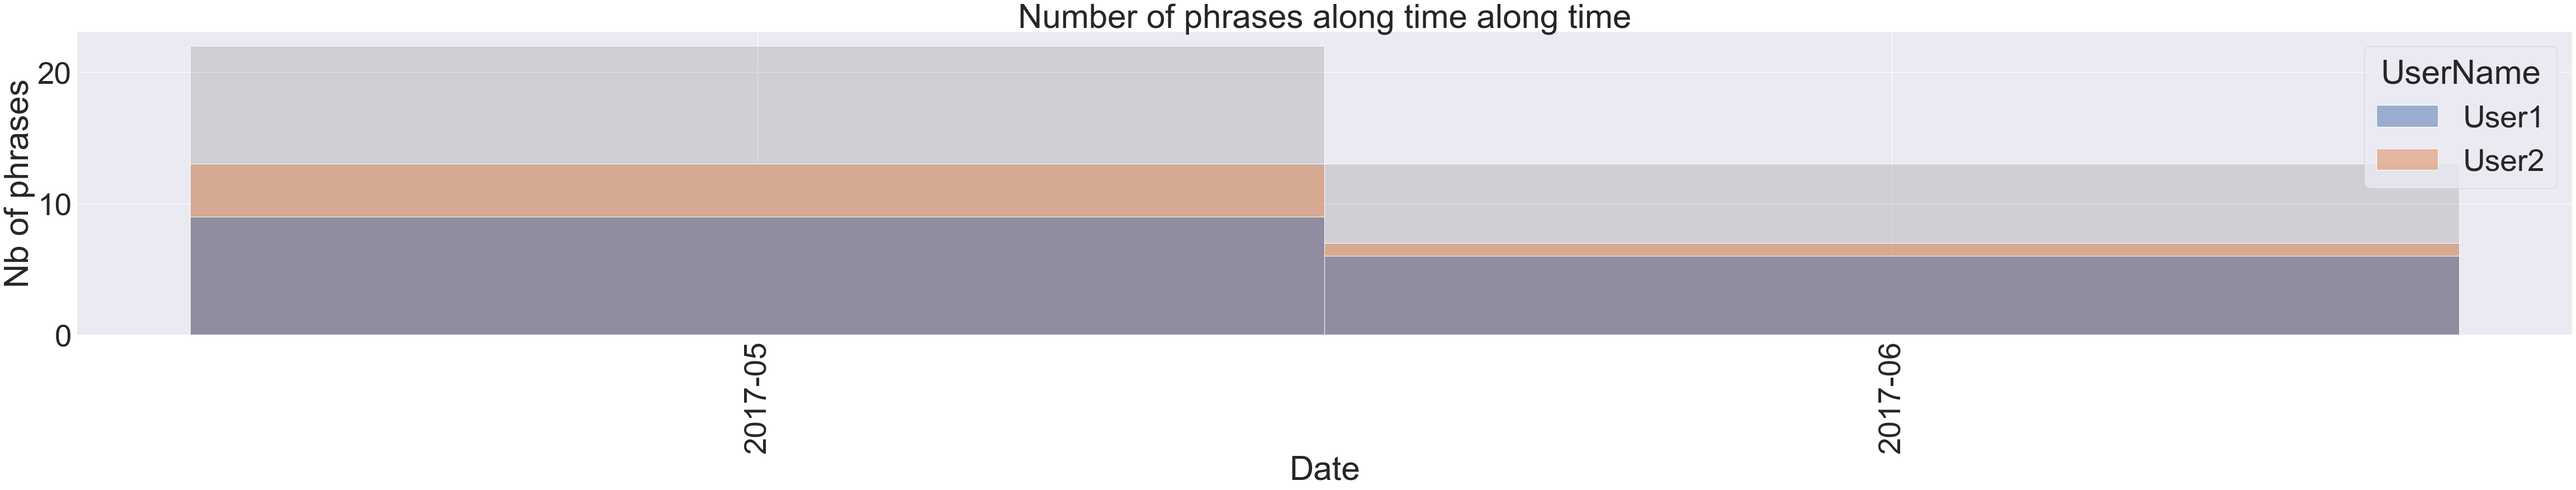

In [53]:
plot_val_along_time(phrase_per_month, x_col="Month", hue="UserName", plot_type="histplot",
                    title="Number of phrases along time along time", x_label="Date", y_label="Nb of phrases", 
                    savepath=os.path.join(FOLDER_NAME,"phrase_time.png"))

If your conversation is short, some phrases may appear as most frequent but just appear one time.

In [54]:
# Find most frequent phrases and the frequency
count = most_freq_phrase_df.head(50)["Count"].values
phrases = most_freq_phrase_df.head(50).index.values
most_common_phrases = dict((c, w) for c, w in zip(count, phrases))

print(most_common_phrases)

{1: 'sorry i was with my boyfriend'}


In [55]:
most_common_phrases_user_l = []
for i, user in enumerate(users):
    print("For user: "+user)
    count = all_phrase_count_per_user_l[i].head(20)["Count"].values
    phrases = all_phrase_count_per_user_l[i].head(20).index.values
    most_common_phrases_user= dict((c, w) for c, w in zip(count, phrases))
    most_common_phrases_user_l.append(most_common_phrases_user)
    print(most_common_phrases_user)
    print("")

For user: User1
{1: 'sorry i was with my boyfriend'}

For user: User2
{1: 'i want to say something important about us'}



## 4. Search phrase or word in dataset

In [56]:
# Select the phrase to search
phrase_to_find = "demain"

# Apply same transformation to the string as we did on the phrase column
phrase_to_find = pd.DataFrame([phrase_to_find])
phrase_to_find = (phrase_to_find[0].str.lower() 
                            .str.replace(r'\\n',' ', regex=True) 
                            .str.replace(r'\n',' ', regex=True) 
                            .str.replace(emoji_pattern, '') 
                            .str.strip() 
                            .astype(str) 
                          )
# Find the messages containing itt
df[df['MessagePhrase'].str.contains(phrase_to_find.iloc[0])]

,MessageBody,Date,UserName,Time,Month,FullDate,MessagePhrase,PhraseCount,MessageWord,WordCount,MessageWordWithoutStopWord,WordCountNonStop


## 5. PDF generation

Generates a (ugly) PDF with the plots and data of the above.

Inspired from https://www.blog.pythonlibrary.org/2010/03/08/a-simple-step-by-step-reportlab-tutorial/

In [57]:
if PDF:
    # Libraries
    from reportlab.lib.enums import TA_JUSTIFY
    from reportlab.lib.pagesizes import letter
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch

    # Create the document
    doc = SimpleDocTemplate(PDF_NAME,pagesize=letter,
                            rightMargin=72,leftMargin=72,
                            topMargin=18,bottomMargin=18)
    styles=getSampleStyleSheet()
    styles.add(ParagraphStyle(name='Justify', alignment=TA_JUSTIFY))

    # Create the array with the different parts of the doc
    Story=[]

    # HEADER
    # Add title and date of file creation
    Story.append(Paragraph("<u>Discussion analysis of this Whats'App discussion generated on: %s</u>" % time.ctime(), styles["Normal"]))
    Story.append(Paragraph("Application developped by Ivan-Daniel Sievering, contact me at ivan.daniel.sievering@gmail.com", styles["Normal"]))
    Story.append(Spacer(1, 12))
    # Add users in the conv
    users_str = "<b>Users in the discussion:</b> "
    for user in users:
        users_str += str(user)+" and "
    users_str = users_str[:-5] # remove the last " and "
    Story.append(Paragraph(users_str, styles["Normal"]))
    # General stat
    Story.append(Spacer(1, 12))
    Story.append(Paragraph("<b>{} messages have been sent, they contain in total {} phrases and {} words.</b>".format(
        total_nb_msg, tot_nb_phrase, tot_nb_words), styles["Normal"]))
    Story.append(Spacer(1, 12))

    # NB MSGS
    Story.append(Paragraph("<b>Number of messages sent per day:</b>"))
    Story.append(Paragraph("General: {:.2f} (mean) {:.0f} (median)".format(msg_count_stats[0], msg_count_stats[1])))
    for i, user in enumerate(users):
        Story.append(Paragraph(user+": {:.2f} (mean) {:.0f} (median)".format(msg_count_stats_per_user[0][i],msg_count_stats_per_user[1][i]), styles["Normal"]))
    Story.append(Spacer(1, 12))
    im = Image(os.path.join(FOLDER_NAME,"nb_msg_time.png"), 8*inch, 2*inch)
    Story.append(im)

    # NB WORDS
    Story.append(Paragraph("<b>Number of words sent per day:</b>"))
    Story.append(Paragraph("General: {:.2f} (mean) {:.0f} (median)".format(words_stats[0], words_stats[1])))
    for i, user in enumerate(users):
        Story.append(Paragraph(user+": {:.2f} (mean) {:.0f} (median)".format(words_stats_per_user[0][i],words_stats_per_user[1][i]), styles["Normal"]))
    Story.append(Spacer(1, 12))
    Story.append(Paragraph("<b>Most used words (without stopwords) are:</b>"))
    words_str = ""
    for word in most_common_words_non_stop:
        words_str = words_str +  ", " + str(word[0])
    words_str += "."
    words_str = words_str[2:] #remove first ", "
    Story.append(Paragraph(words_str, styles["Justify"]))
    Story.append(Spacer(1, 12))
    for i, user in enumerate(users):
        Story.append(Paragraph("<b>Most used words (without stopwords) by {} are:</b>".format(user)))
        words_str = ""
        for word in all_words_no_stop_count_per_user_l[i].most_common(30):
            words_str = words_str +  ", " + str(word[0])
        words_str += "."
        words_str = words_str[2:] #remove first ", "
        Story.append(Paragraph(words_str, styles["Justify"]))
        Story.append(Spacer(1, 12))
    im = Image(os.path.join(FOLDER_NAME,"words_time.png"), 8*inch, 2*inch)
    Story.append(im)

    # NB PHRASES
    Story.append(Paragraph("<b>Number of phrases sent per day:</b>"))
    Story.append(Paragraph("General: {:.2f} (mean) {:.0f} (median)".format(phrases_stats[0], phrases_stats[1])))
    for i, user in enumerate(users):
        Story.append(Paragraph(user+": {:.2f} (mean) {:.0f} (median)".format(phrases_stats_per_user[0][i],phrases_stats_per_user[1][i]), styles["Normal"]))
    Story.append(Spacer(1, 12))
    Story.append(Paragraph("<b>Most used phrases are:</b>"))
    phrase_str = ""
    for phrase in most_common_phrases.values():
        phrase_str = phrase_str +  ", " + str(phrase)
    phrase_str += "."
    phrase_str = phrase_str[2:] #remove first ", "
    Story.append(Paragraph(phrase_str, styles["Justify"]))
    Story.append(Spacer(1, 12))
    for i, user in enumerate(users):
        Story.append(Paragraph("<b>Most used phrases by {} are:</b>".format(user)))
        phrase_str = ""
        for phrase in most_common_phrases_user_l[i].values():
            phrase_str = phrase_str +  ", " + str(phrase)
        phrase_str += "."
        phrase_str = phrase_str[2:] #remove first ", "
        Story.append(Paragraph(phrase_str, styles["Justify"]))
        Story.append(Spacer(1, 12))
    im = Image(os.path.join(FOLDER_NAME,"phrase_time.png"), 8*inch, 2*inch)
    Story.append(im)

    # RESPONSE TIME
    Story.append(Paragraph("<b>Time to answer (minutes):</b>"))
    Story.append(Paragraph("General: {:.2f} (mean) {:.0f} (median)".format(response_time_stats[0], response_time_stats[1])))
    for i, user in enumerate(users):
        Story.append(Paragraph(user+": {:.2f} (mean) {:.0f} (median)".format(response_time_stats_per_user[0][i],response_time_stats_per_user[1][i]), styles["Normal"]))
    Story.append(Spacer(1, 12))
    im = Image(os.path.join(FOLDER_NAME,"delay_time.png"), 8*inch, 2*inch)
    Story.append(im)


    # DISCUSSION
    # Number per month
    Story.append(Paragraph("<b>There is a total of {} discussion.</b>".format(nb_discussion)))
    Story.append(Paragraph("A discussion has been defined when both user sent messages, at least {} messages have been exchange and they are espaced by a maximum of {} minutes.".format(NB_MSG_TH, RESPONSE_TIME_TH), styles["Justify"]))
    if nb_discussion == 0 :
        print("Not enough discussion for stats on it.")
    else:
        Story.append(Paragraph("<b>Number of discussions per month:</b>"))
        Story.append(Paragraph("General: {:.2f} (mean) {:.0f} (median)".format(nb_disc_stats[0], nb_disc_stats[1])))
        Story.append(Spacer(1, 12))
        im = Image(os.path.join(FOLDER_NAME,"nb_disc_time.png"), 8*inch, 2*inch)
        Story.append(im)
    # percentage of the message
    if nb_discussion > 0:
        Story.append(Paragraph("<b>Percentage of messages in discussion:</b>"))
        Story.append(Paragraph("General: {:.2f}% (mean) {:.2f}% (median)".format(perc_disc_stats[0], perc_disc_stats[1])))
        Story.append(Spacer(1, 12))
        im = Image(os.path.join(FOLDER_NAME,"perc_disc_time.png"), 8*inch, 2*inch)
        Story.append(im)
    # time spent
    if nb_discussion > 0:
        Story.append(Paragraph("<b>Total time spent in discussion is {:.2f} hours.</b>".format(tot_time_spent_disc_h)))
        Story.append(Paragraph("<b>Time spent in discussion per month:</b>"))
        Story.append(Paragraph("General: {:.2f} (mean) {:.2f} (median)".format(time_disc_stats[0], time_disc_stats[1])))
        Story.append(Spacer(1, 12))
        im = Image(os.path.join(FOLDER_NAME,"time_disc_time.png"), 8*inch, 2*inch)
        Story.append(im)

    # Create document
    doc.build(Story)

-------------------------------